In [3]:
#爬取中国天气网-西安气象数据
import requests
from bs4 import BeautifulSoup
import csv
import json

"""请求获得网页内容"""
def getHTMLtext(url):
    try:
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        r.encoding = r.apparent_encoding
        print("成功访问")
        return r.text
    except:
        print("访问错误")
        return " "
    
"""处理得到有用信息保存数据文件"""
def get_content(html):
    final = []  # 初始化一个列表保存数据
    bs = BeautifulSoup(html, "html.parser")  # 创建BeautifulSoup对象
    body = bs.body
    data = body.find('div', {'id': '7d'})  # 找到div标签且id = 7d
    # 下面爬取当天的数据
    data2 = body.find_all('div', {'class': 'left-div'})
    text = data2[2].find('script').string
    text = text[text.index('=') + 1:-2]  # 移除改var data=将其变为json数据
    jd = json.loads(text)
    dayone = jd['od']['od2']  # 找到当天的数据
    final_day = []  # 存放当天的数据
    count = 0
    for i in dayone:
        temp = []
        if count <= 23:
            temp.append(i['od21'])  # 时间
            temp.append(i['od22'])  # 当前时刻温度
            temp.append(i['od24'])  # 当前时刻风力方向
            temp.append(i['od25'])  # 当前时刻风级
            temp.append(i['od26'])  # 当前时刻降水量
            temp.append(i['od27'])  # 当前时刻相对湿度
            temp.append(i['od28'])  # 当前时刻控制质量
            # print(temp)
            final_day.append(temp)
        count = count + 1
    # 下面爬取7天的数据
    ul = data.find('ul')  # 找到所有的ul标签
    li = ul.find_all('li')  # 找到左右的li标签
    i = 0  # 控制爬取的天数
    for day in li:  # 遍历找到的每一个li
        if i < 7 and i > 0:
            temp = []  # 临时存放每天的数据
            date = day.find('h1').string  # 得到日期
            date = date[0:date.index('日')]  # 取出日期号
            temp.append(date)
            inf = day.find_all('p')  # 找出li下面的p标签,提取第一个p标签的值，即天气
            temp.append(inf[0].string)

            tem_low = inf[1].find('i').string  # 找到最低气温

            if inf[1].find('span') is None:  # 天气预报可能没有最高气温
                tem_high = None
            else:
                tem_high = inf[1].find('span').string  # 找到最高气温
            temp.append(tem_low[:-1])
            if tem_high[-1] == '℃':
                temp.append(tem_high[:-1])
            else:
                temp.append(tem_high)

            wind = inf[2].find_all('span')  # 找到风向
            for j in wind:
                temp.append(j['title'])

            wind_scale = inf[2].find('i').string  # 找到风级
            index1 = wind_scale.index('级')
            temp.append(int(wind_scale[index1 - 1:index1]))
            final.append(temp)
        i = i + 1
    return final_day, final

In [5]:
"""处理得到有用信息保存14天数据文件"""
def get_content2(html):
    final = []  
    bs = BeautifulSoup(html, "html.parser") 
    body = bs.body
    data = body.find('div', {'id': '15d'})  # 找到div标签且id = 15d
    ul = data.find('ul')  # 找到所有的ul标签
    li = ul.find_all('li')  # 找到左右的li标签
    final = []
    i = 0  
    for day in li:  
        if i < 8:
            temp = []  # 临时存放每天的数据
            date = day.find('span', {'class': 'time'}).string  # 得到日期
            date = date[date.index('（') + 1:-2]  # 取出日期号
            temp.append(date)
            weather = day.find('span', {'class': 'wea'}).string  # 找到天气
            temp.append(weather)
            tem = day.find('span', {'class': 'tem'}).text  # 找到温度
            temp.append(tem[tem.index('/') + 1:-1])  # 找到最低气温
            temp.append(tem[:tem.index('/') - 1])  # 找到最高气温
            wind = day.find('span', {'class': 'wind'}).string  # 找到风向
            if '转' in wind:  # 如果有风向变化
                temp.append(wind[:wind.index('转')])
                temp.append(wind[wind.index('转') + 1:])
            else:  # 如果没有风向变化，前后风向一致
                temp.append(wind)
                temp.append(wind)
            wind_scale = day.find('span', {'class': 'wind1'}).string  # 找到风级
            index1 = wind_scale.index('级')
            temp.append(int(wind_scale[index1 - 1:index1]))

            final.append(temp)
    return final


In [6]:
def write_to_csv(file_name, data, day=14):
    """保存为csv文件"""
    with open(file_name, 'a', errors='ignore', newline='') as f:
        if day == 14:
            header = ['日期', '天气', '最低气温', '最高气温', '风向1', '风向2', '风级']
        else:
            header = ['小时', '温度', '风力方向', '风级', '降水量', '相对湿度', '空气质量']
        f_csv = csv.writer(f)
        f_csv.writerow(header)
        f_csv.writerows(data)

def main():
    """主函数"""
    print("XI'AN Weather_data test")
    url1 = 'http://www.weather.com.cn/weather/101110101.shtml'  # 1-7天天气中国天气网
    url2 = 'http://www.weather.com.cn/weather15d/101110101.shtml'  # 8-15天天气中国天气网

    html1 = getHTMLtext(url1)
    data1, data1_7 = get_content(html1)  # 获得7天和当天的数据

    html2 = getHTMLtext(url2)
    data8_14 = get_content2(html2)  # 获得8-14天数据
    data14 = data1_7 + data8_14
    # print(data14)
    write_to_csv('./data/weather14.csv', data14, 14)  # 保存为csv文件
    write_to_csv('./data/weather1.csv', data1, 1)


if __name__ == '__main__':
    main()


XI'AN Weather_data test
成功访问
成功访问


In [12]:
#查看1天数据
f1=open("./data/weather1.csv",'r')
reader1=csv.reader(f1)
for item1 in reader1:
    print(item1)
f1.close()


['小时', '温度', '风力方向', '风级', '降水量', '相对湿度', '空气质量']
['20', '-5', '西北风', '1', '0', '37', '57']
['19', '-4', '西南风', '1', '0', '31', '52']
['18', '-3', '南风', '1', '0', '27', '50']
['17', '-1', '西南风', '1', '0', '22', '49']
['16', '0', '东南风', '1', '0', '19', '46']
['15', '0', '东南风', '2', '0', '17', '50']
['14', '0', '南风', '2', '0', '17', '58']
['13', '-2', '东南风', '1', '0', '23', '68']
['12', '-3', '西风', '2', '0', '30', '77']
['11', '-5', '西北风', '2', '0', '47', '82']
['10', '-7', '西北风', '2', '0', '52', '88']
['09', '-8', '西北风', '2', '0', '57', '87']
['08', '-7', '南风', '2', '0', '51', '76']
['07', '-8', '西北风', '1', '0', '56', '78']
['06', '-8', '西北风', '1', '0', '54', '76']
['05', '-8', '西风', '1', '0', '55', '80']
['04', '-9', '西北风', '1', '0', '55', '79']
['03', '-8', '西风', '1', '0', '47', '80']
['02', '-7', '西南风', '1', '0', '47', '79']
['01', '-7', '南风', '1', '0', '40', '79']
['00', '-7', '西风', '1', '0', '44', '78']
['23', '-6', '西南风', '1', '0', '40', '76']
['22', '-6', '西风', '1', '0', '39', '6

In [13]:
#查看14天数据
with open("./data/weather14.csv",'r') as f2:
    reader2=csv.reader(f2)
    for item2 in reader2:
        print(item2)
    f2.close()

['日期', '天气', '最低气温', '最高气温', '风向1', '风向2', '风级']
['9', '阴', '-10', '3', '东北风', '西南风', '3']
['10', '阴转晴', '-5', '3', '西风', '西风', '4']
['11', '晴', '-4', '8', '西风', '南风', '4']
['12', '晴', '-3', '12', '南风', '南风', '3']
['13', '晴', '-2', '12', '西南风', '东北风', '3']
['14', '晴转多云', '-3', '10', '东北风', '东北风', '3']
['15', '晴转阴', '-2', '10', '东北风', '西风', '4']
['16', '多云转阴', '-4', '6', '西南风', '东北风', '3']
['17', '晴', '-4', '6', '南风', '东北风', '3']
['18', '晴', '-4', '12', '南风', '西南风', '3']
['19', '晴', '1', '10', '西南风', '西北风', '3']
['20', '多云转阴', '1', '11', '南风', '南风', '3']
['21', '晴转多云', '0', '10', '南风', '西南风', '3']
['22', '多云', '0', '7', '南风', '西风', '3']


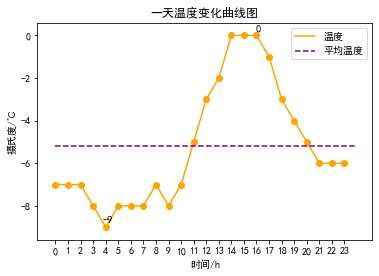

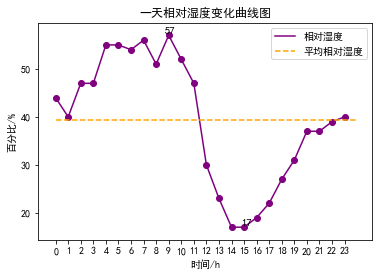

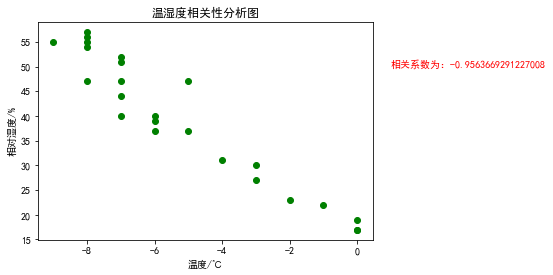

相关系数为：-0.9563669291227008
<class 'int'>


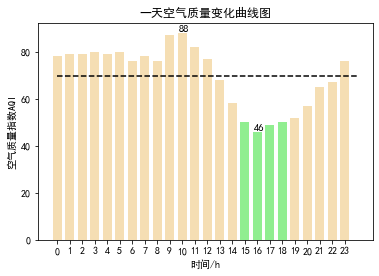

[0, 0, 1.375, 1.2, 1.0, 1.5, 1.3333333333333333, 0]


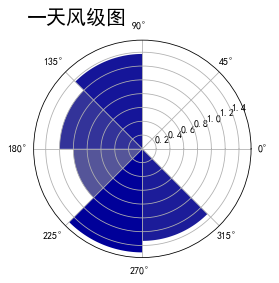

In [30]:
#1天数据可视化分析 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math


"""温度曲线绘制"""
def tem_curve(data):
    hour = list(data['小时'])
    tem = list(data['温度'])
    for i in range(0, 24):
        if math.isnan(tem[i]) == True:
            tem[i] = tem[i - 1]
    tem_ave = sum(tem) / 24  # 求平均温度
    tem_max = max(tem)
    tem_max_hour = hour[tem.index(tem_max)]  # 求最高温度
    tem_min = min(tem)
    tem_min_hour = hour[tem.index(tem_min)]  # 求最低温度
    x = []
    y = []
    for i in range(0, 24):
        x.append(i)
        y.append(tem[hour.index(i)])
    plt.figure(1)
    plt.plot(x, y, color='orange', label='温度')  # 画出温度曲线
    plt.scatter(x, y, color='orange')  # 点出每个时刻的温度点
    plt.plot([0, 24], [tem_ave, tem_ave], c='purple', linestyle='--', label='平均温度')  # 画出平均温度虚线
    plt.text(tem_max_hour + 0.15, tem_max + 0.15, str(tem_max), ha='center', va='bottom', fontsize=10.5)  # 标出最高温度
    plt.text(tem_min_hour + 0.15, tem_min + 0.15, str(tem_min), ha='center', va='bottom', fontsize=10.5)  # 标出最低温度
    plt.xticks(x)
    plt.legend()
    plt.title('一天温度变化曲线图')
    plt.xlabel('时间/h')
    plt.ylabel('摄氏度/℃')
    plt.show()

    
"""相对湿度曲线绘制"""
def hum_curve(data):
    hour = list(data['小时'])
    hum = list(data['相对湿度'])
    for i in range(0, 24):
        if math.isnan(hum[i]) == True:
            hum[i] = hum[i - 1]
    hum_ave = sum(hum) / 24  # 求平均相对湿度
    hum_max = max(hum)
    hum_max_hour = hour[hum.index(hum_max)]  # 求最高相对湿度
    hum_min = min(hum)
    hum_min_hour = hour[hum.index(hum_min)]  # 求最低相对湿度
    x = []
    y = []
    for i in range(0, 24):
        x.append(i)
        y.append(hum[hour.index(i)])
    plt.figure(2)
    plt.plot(x, y, color='purple', label='相对湿度')  # 画出相对湿度曲线
    plt.scatter(x, y, color='purple')  # 点出每个时刻的相对湿度
    plt.plot([0, 24], [hum_ave, hum_ave], c='orange', linestyle='--', label='平均相对湿度')  # 画出平均相对湿度虚线
    plt.text(hum_max_hour + 0.15, hum_max + 0.15, str(hum_max), ha='center', va='bottom', fontsize=10.5)  # 标出最高相对湿度
    plt.text(hum_min_hour + 0.15, hum_min + 0.15, str(hum_min), ha='center', va='bottom', fontsize=10.5)  # 标出最低相对湿度
    plt.xticks(x)
    plt.legend()
    plt.title('一天相对湿度变化曲线图')
    plt.xlabel('时间/h')
    plt.ylabel('百分比/%')
    plt.show()

    
"""空气质量曲线绘制"""
def air_curve(data):
    hour = list(data['小时'])
    air = list(data['空气质量'])
    print(type(air[0]))
    for i in range(0, 24):
        if math.isnan(air[i]) == True:
            air[i] = air[i - 1]
    air_ave = sum(air) / 24  # 求平均空气质量
    air_max = max(air)
    air_max_hour = hour[air.index(air_max)]  # 求最高空气质量
    air_min = min(air)
    air_min_hour = hour[air.index(air_min)]  # 求最低空气质量
    x = []
    y = []
    for i in range(0, 24):
        x.append(i)
        y.append(air[hour.index(i)])
    plt.figure(3)

    for i in range(0, 24):
        if y[i] <= 50:
            plt.bar(x[i], y[i], color='lightgreen', width=0.7)  # 1等级
        elif y[i] <= 100:
            plt.bar(x[i], y[i], color='wheat', width=0.7)  # 2等级
        elif y[i] <= 150:
            plt.bar(x[i], y[i], color='orange', width=0.7)  # 3等级
        elif y[i] <= 200:
            plt.bar(x[i], y[i], color='orangered', width=0.7)  # 4等级
        elif y[i] <= 300:
            plt.bar(x[i], y[i], color='darkviolet', width=0.7)  # 5等级
        elif y[i] > 300:
            plt.bar(x[i], y[i], color='maroon', width=0.7)  # 6等级
    plt.plot([0, 24], [air_ave, air_ave], c='black', linestyle='--')  # 画出平均空气质量虚线
    plt.text(air_max_hour + 0.15, air_max + 0.15, str(air_max), ha='center', va='bottom', fontsize=10.5)  # 标出最高空气质量
    plt.text(air_min_hour + 0.15, air_min + 0.15, str(air_min), ha='center', va='bottom', fontsize=10.5)  # 标出最低空气质量
    plt.xticks(x)
    plt.title('一天空气质量变化曲线图')
    plt.xlabel('时间/h')
    plt.ylabel('空气质量指数AQI')
    plt.show()

    
"""风向雷达图"""
def wind_radar(data):
    wind = list(data['风力方向'])
    wind_speed = list(data['风级'])
    for i in range(0, 24):
        if wind[i] == "北风":
            wind[i] = 90
        elif wind[i] == "南风":
            wind[i] = 270
        elif wind[i] == "西风":
            wind[i] = 180
        elif wind[i] == "东风":
            wind[i] = 360
        elif wind[i] == "东北风":
            wind[i] = 45
        elif wind[i] == "西北风":
            wind[i] = 135
        elif wind[i] == "西南风":
            wind[i] = 225
        elif wind[i] == "东南风":
            wind[i] = 315
    degs = np.arange(45, 361, 45)
    temp = []
    for deg in degs:
        speed = []
        # 获取 wind_deg 在指定范围的风速平均值数据
        for i in range(0, 24):
            if wind[i] == deg:
                speed.append(wind_speed[i])
        if len(speed) == 0:
            temp.append(0)
        else:
            temp.append(sum(speed) / len(speed))
    print(temp)
    N = 8
    theta = np.arange(0. + np.pi / 8, 2 * np.pi + np.pi / 8, 2 * np.pi / 8)
    # 数据极径
    radii = np.array(temp)
    # 绘制极区图坐标系
    plt.axes(polar=True)
    # 定义每个扇区的RGB值（R,G,B），x越大，对应的颜色越接近蓝色
    colors = [(1 - x / max(temp), 1 - x / max(temp), 0.6) for x in radii]
    plt.bar(theta, radii, width=(2 * np.pi / N), bottom=0.0, color=colors)
    plt.title('一天风级图', x=0.2, fontsize=20)
    plt.show()


"""计算相关系数"""
def calc_corr(a, b):
    a_avg = sum(a) / len(a)
    b_avg = sum(b) / len(b)
    cov_ab = sum([(x - a_avg) * (y - b_avg) for x, y in zip(a, b)])
    sq = math.sqrt(sum([(x - a_avg) ** 2 for x in a]) * sum([(x - b_avg) ** 2 for x in b]))
    corr_factor = cov_ab / sq
    return corr_factor


"""温湿度相关性分析"""
def corr_tem_hum(data):
    tem = data['温度']
    hum = data['相对湿度']
    plt.scatter(tem, hum, color='green')
    plt.title("温湿度相关性分析图")
    plt.xlabel("温度/℃")
    plt.ylabel("相对湿度/%")
    plt.text(1,50, "相关系数为：" + str(calc_corr(tem, hum)), fontdict={'size': '10', 'color': 'red'})
    plt.show()
    print("相关系数为：" + str(calc_corr(tem, hum)))


def main():
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    data1 = pd.read_csv('./data/weather1.csv', encoding='gb2312')
    #print(data1)
    tem_curve(data1)
    hum_curve(data1)
    corr_tem_hum(data1)
    air_curve(data1)
    wind_radar(data1)
    

if __name__ == '__main__':
    main()


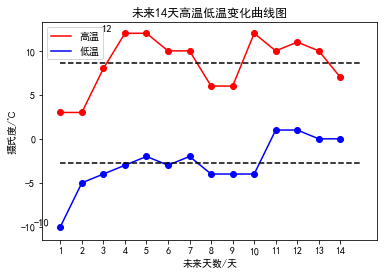

[3.142857142857143, 0, 3.0, 3.8, 3.0, 3.111111111111111, 0, 0]


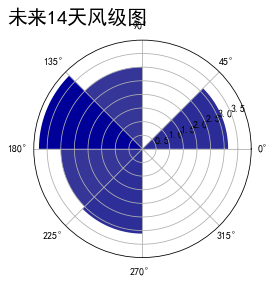

{'阴': 1, '阴转晴': 1, '晴': 6, '晴转多云': 2, '晴转阴': 1, '多云转阴': 2, '多云': 1}


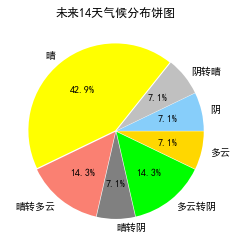

In [36]:
# 14天数据可视化分析
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math


"""温度曲线绘制"""
def tem_curve(data):   
    date = list(data['日期'])
    tem_low = list(data['最低气温'])
    tem_high = list(data['最高气温'])
    for i in range(0, 14):
        if math.isnan(tem_low[i]) == True:
            tem_low[i] = tem_low[i - 1]
        if math.isnan(tem_high[i]) == True:
            tem_high[i] = tem_high[i - 1]

    tem_high_ave = sum(tem_high) / 14  # 求平均高温
    tem_low_ave = sum(tem_low) / 14  # 求平均低温

    tem_max = max(tem_high)
    tem_max_date = tem_high.index(tem_max)  # 求最高温度
    tem_min = min(tem_low)
    tem_min_date = tem_low.index(tem_min)  # 求最低温度

    x = range(1, 15)
    plt.figure(1)
    plt.plot(x, tem_high, color='red', label='高温')  # 画出高温度曲线
    plt.scatter(x, tem_high, color='red')  # 点出每个时刻的温度点
    plt.plot(x, tem_low, color='blue', label='低温')  # 画出低温度曲线
    plt.scatter(x, tem_low, color='blue')  # 点出每个时刻的温度点

    plt.plot([1, 15], [tem_high_ave, tem_high_ave], c='black', linestyle='--')  # 画出平均温度虚线
    plt.plot([1, 15], [tem_low_ave, tem_low_ave], c='black', linestyle='--')  # 画出平均温度虚线
    plt.legend()
    plt.text(tem_max_date + 0.15, tem_max + 0.15, str(tem_max), ha='center', va='bottom', fontsize=10.5)  # 标出最高温度
    plt.text(tem_min_date + 0.15, tem_min + 0.15, str(tem_min), ha='center', va='bottom', fontsize=10.5)  # 标出最低温度
    plt.xticks(x)
    plt.title('未来14天高温低温变化曲线图')
    plt.xlabel('未来天数/天')
    plt.ylabel('摄氏度/℃')
    plt.show()


"""改变风向"""
def change_wind(wind):
    for i in range(0, 14):
        if wind[i] == "北风":
            wind[i] = 90
        elif wind[i] == "南风":
            wind[i] = 270
        elif wind[i] == "西风":
            wind[i] = 180
        elif wind[i] == "东风":
            wind[i] = 360
        elif wind[i] == "东北风":
            wind[i] = 45
        elif wind[i] == "西北风":
            wind[i] = 135
        elif wind[i] == "西南风":
            wind[i] = 225
        elif wind[i] == "东南风":
            wind[i] = 315
    return wind


"""风向雷达图"""
def wind_radar(data):
    wind1 = list(data['风向1'])
    wind2 = list(data['风向2'])
    wind_speed = list(data['风级'])
    wind1 = change_wind(wind1)
    wind2 = change_wind(wind2)

    degs = np.arange(45, 361, 45)
    temp = []
    for deg in degs:
        speed = []
        # 获取 wind_deg 在指定范围的风速平均值数据
        for i in range(0, 14):
            if wind1[i] == deg:
                speed.append(wind_speed[i])
            if wind2[i] == deg:
                speed.append(wind_speed[i])
        if len(speed) == 0:
            temp.append(0)
        else:
            temp.append(sum(speed) / len(speed))
    print(temp)
    N = 8
    theta = np.arange(0. + np.pi / 8, 2 * np.pi + np.pi / 8, 2 * np.pi / 8)
    # 数据极径
    radii = np.array(temp)
    # 绘制极区图坐标系
    plt.axes(polar=True)
    # 定义每个扇区的RGB值（R,G,B），x越大，对应的颜色越接近蓝色
    colors = [(1 - x / max(temp), 1 - x / max(temp), 0.6) for x in radii]
    plt.bar(theta, radii, width=(2 * np.pi / N), bottom=0.0, color=colors)
    plt.title('未来14天风级图', x=0.2, fontsize=20)
    plt.show()


"""绘制天气饼图"""
def weather_pie(data):    
    weather = list(data['天气'])
    dic_wea = {}
    for i in range(0, 14):
        if weather[i] in dic_wea.keys():
            dic_wea[weather[i]] += 1
        else:
            dic_wea[weather[i]] = 1
    print(dic_wea)
    explode = [0.01] * len(dic_wea.keys())
    color = ['lightskyblue', 'silver', 'yellow', 'salmon', 'grey', 'lime', 'gold', 'red', 'green', 'pink']
    plt.pie(dic_wea.values(), explode=explode, labels=dic_wea.keys(), autopct='%1.1f%%', colors=color)
    plt.title('未来14天气候分布饼图')
    plt.show()


def main():
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    data14 = pd.read_csv('./data/weather14.csv', encoding='gb2312')
    #print(data14)
    tem_curve(data14)
    wind_radar(data14)
    weather_pie(data14)


if __name__ == '__main__':
    main()
